# Clustering methods applied to FTS transfer error messages

**Objective:** 

 - extract FTS transfer error data
 - load language model
 - perform cluster analysis
 
**N.B.** The last part is a test on the abstraction mechanism for messages parameters. Also, a training on unique error strings approach is investigated.

### Spark Session 

In [1]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("fts_clustering").getOrCreate()
#spark = SparkSession.builder.master("local[*]").appName("fts_data").getOrCreate()
spark

CPU times: user 38.5 ms, sys: 32 ms, total: 70.5 ms
Wall time: 8.87 s


## Import data

**Note:** the period 7/10 - 10/10 is considered since there should be an issue with an FTS instance and we want our approach to be able to spot it.

In [2]:
# train_data = spark.read.csv("train_subsample.csv", header=True)

test_data = spark.read.csv("test_data.csv", header=True)

## Pre-processing 

In [3]:
def deal_with_urls(url):
    from urllib.parse import urlparse
    parsed = urlparse(url)
    if parsed.scheme:
        if parsed.path and parsed.netloc:
            res = ' '.join([parsed.scheme + "://" + parsed.netloc, parsed.path])
        elif parsed.path:
            res = parsed.scheme + ":" + parsed.path
        else:
            res = parsed.scheme + ":"
    else:
        res = parsed.path
    return(res)

def split_urls(string):
    '''Take a string and split url into netloc + path'''
    from urllib.parse import urlparse
    tks = [deal_with_urls(x) for x in string.split()]
    return(' '.join(tks))


def split_concatenation_errors(string, split_char="-"):
    """"""   
    if split_char in string:
        try:
            int(string.split(split_char)[0])
            number = string.split(split_char)[0]
            literal = string.replace(number+split_char, "")
            return([number, literal])
        except ValueError:
            return(string)
    else:
        return(string)

def clean_tokens(entry, custom_split=False):
    """Remove punctuation at the end of tokens and disard empty tokens"""
    def flatten(ul):
        """"""
        fl = []
        for i in ul:
            if type(i) is list:
                fl += flatten(i)
            else:
                fl += [i]
        return fl
    
    if custom_split:
        tks_cleaned = [split_concatenation_errors(tks.strip(":;,.- ")) 
                       for tks in entry if tks!=""]
        tks_cleaned = flatten(tks_cleaned)
    else:
        tks_cleaned = [tks.strip(":;,.- ") for tks in entry if tks!=""]
    return(tks_cleaned)

In [4]:
import pyspark.sql.functions as F

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType

# transform in user defined function
split_urls_udf = udf(split_urls, StringType())

# split urls appropriately
# test_data = test_data.select("t__error_message").withColumn("corrected_message", split_urls_udf("t__error_message"))
test_data = test_data.select("t__error_message").distinct().withColumn("corrected_message", split_urls_udf("t__error_message"))

# add row id
test_data = test_data.withColumn("msg_id", F.monotonically_increasing_id()).select("msg_id", "t__error_message", "corrected_message")

In [5]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# split text into tokens
tokenizer = Tokenizer(inputCol="corrected_message", outputCol="tokens")
vector_data = tokenizer.transform(test_data)

# transform in user defined function
clean_tokens_udf = udf(lambda entry: clean_tokens(entry, custom_split=True), ArrayType(StringType()))

# clean tokens
vector_data = vector_data.withColumn("tokens_cleaned", clean_tokens_udf("tokens"))

# remove stop (common, non-relevant) words
stop_remove = StopWordsRemover(inputCol="tokens_cleaned", outputCol="stop_token")
stop_remove1 = StopWordsRemover(inputCol="stop_token", outputCol="stop_token_1", stopWords=["", ":", "-"])

In [6]:
from pyspark.ml import Pipeline

data_prep_pipeline = Pipeline(stages = [stop_remove, stop_remove1])

pipeline_executor = data_prep_pipeline.fit(vector_data)

In [7]:
%%time

vector_data = pipeline_executor.transform(vector_data)

CPU times: user 52.1 ms, sys: 8.76 ms, total: 60.9 ms
Wall time: 181 ms


In [8]:
vector_data.count()

173920

In [8]:
# subsample data
sub1 = vector_data.sample(withReplacement=False, fraction=0.3, seed=4)

<div class="alert alert-block alert-info">
    <b>Note:</b> I should probably scale the stop_words column before feeding it into word2vec model.
</div>

In [ ]:
# from pyspark.ml.feature import StandardScaler
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# # Compute summary statistics by fitting the StandardScaler
# scalerModel = scaler.fit(final_data)

# # Normalize each feature to have unit standard deviation.
# cluster_final_data = scalerModel.transform(final_data)

## Custering 

In [10]:
# load back the word2vec model
from pyspark.ml.feature import Word2VecModel
w2vec_model = Word2VecModel.load('word2vec_trial_random_sample')

# apply it to the data to obtain the embedded representation
# train_data = sub1.select("msg_id", "t__error_message", "stop_token_1")#.limit(500000)
train_data = vector_data.select("msg_id", "t__error_message", "stop_token_1")#.limit(500000)
train_data = w2vec_model.transform(train_data)

In [11]:
# from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [12]:
vec_assembler = VectorAssembler(inputCols = ["message_vector"], outputCol='features')

In [13]:
# format data to feed it into pyspark ML models
train_data = vec_assembler.transform(train_data)

### K-Means 

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [56]:
%%time

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

kmeans_models = []
clustering_model = []
wsse = []
silhouette = []


k_list = []
for i, k in enumerate(range(5,20)):
    k_list.append(k)
    kmeans_models.append(KMeans(featuresCol='features',k=k, initMode='k-means||',
    initSteps=3, tol=0.0001, maxIter=30, distanceMeasure='cosine'))
    clustering_model.append(kmeans_models[i].fit(train_data))
    
    # compute metrics   
    wsse.append(clustering_model[i].summary.trainingCost)
    silhouette.append(evaluator.evaluate(clustering_model[i].summary.predictions))

    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse[i]))
    print("Silhouette with cosine distance = " + str(silhouette[i]))
    print('--'*30)

With K=5
Within Cluster Sum of Squared Errors = 51666.797652992296
Silhouette with cosine distance = 0.7007597856536323
------------------------------------------------------------
With K=6
Within Cluster Sum of Squared Errors = 42417.31205646741
Silhouette with cosine distance = 0.7111873049898064
------------------------------------------------------------
With K=7
Within Cluster Sum of Squared Errors = 37286.29843675361
Silhouette with cosine distance = 0.7406978350996407
------------------------------------------------------------
With K=8
Within Cluster Sum of Squared Errors = 37288.9105021556
Silhouette with cosine distance = 0.7363599013292254
------------------------------------------------------------
With K=9
Within Cluster Sum of Squared Errors = 33573.11620055456
Silhouette with cosine distance = 0.7376167730323601
------------------------------------------------------------
With K=10
Within Cluster Sum of Squared Errors = 34740.83131667538
Silhouette with cosine distance =

##### Saving clustering models 

In [43]:
for i, model in enumerate(kmeans_models):
    model.write().overwrite().save("kmeans_k{}_unique".format(model.getK()))

In [44]:
for i, model in enumerate(clustering_model):
    model.write().overwrite().save("kmeans_k{}_trained_unique".format(model.summary.k))

#### Choice of K

In order to choose the optimal value for the number of clusters, K, I compare the results obtained with different Ks based on two indicators:
 - Sum of Squared Distances Within Groups: $$ \text{WSSE}(\text{dist}, K) = \sum_{k=1}^{K}{\sum_{x_i \in C_k}\text{dist}(x_i, \overline{x}_k)}$$
 
 - Average Silhouette Width: $$ \text{ASW}(\text{dist}, K) = \frac{1}{n} \sum_{i=1}^{n}{\frac{b(i) - a(i)}{\text{max}[a(i), b(i)]}}$$
 where $a(i)$ is the average distance of message $i$ to all the other messages in the same cluster and $b(i)$ is the minimum average distance of message $i$ from messages on another cluster.
 
 $$$$

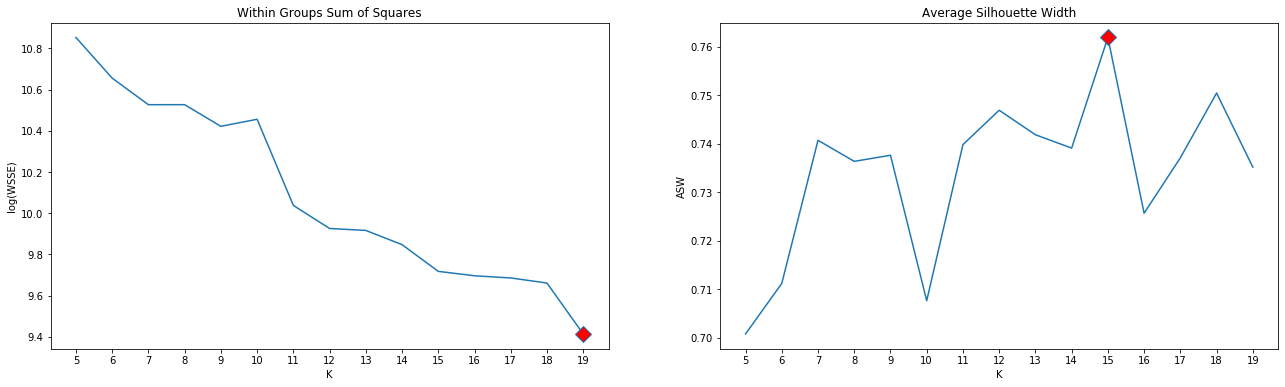

In [130]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(22,6))

best_K_wsse = np.argmin(wsse)
best_K_silhouette = np.argmax(silhouette)

_ = plt.subplot(1,2,1)
_ = plt.plot(k_list, np.log(wsse),'-D', markevery=[best_K_wsse], markerfacecolor='red', markersize=12)
# _ = plt.Circle(xy=(16,16257), radius=3, color="red")
_ = plt.xlabel("K")
_ = plt.ylabel("log(WSSE)")
_ = plt.xticks(k_list)
_ = plt.title("Within Groups Sum of Squares")

_ = plt.subplot(1,2,2)
_ = plt.plot(k_list, silhouette,'-D', markevery=[best_K_silhouette], markerfacecolor='red', markersize=12)
_ = plt.xlabel("K")
_ = plt.ylabel("ASW")
_ = plt.xticks(k_list)
_ = plt.title("Average Silhouette Width")


#### Posterior checks 

In [113]:
# from pyspark.ml.clustering import KMeansModel

# clustering_model = []
# for k in [4,8,12]:
#     clustering_model.append(KMeansModel.load("kmeans_k{}_trained".format(k)))

In [131]:
import numpy as np

for model in clustering_model:
    print("\n\nkmeans: K = {}".format(model.summary.k))
    print("Maximum number of iterations: {}".format(model.summary.numIter))
    
    # sort cluster sizes
    ord_sizes = model.summary.clusterSizes
    ord_idx = list(np.argsort(model.summary.clusterSizes))
    ord_sizes.sort(reverse=True)
    ord_idx.reverse()
    print("Cluster sizes:")
    for el in zip(ord_idx, ord_sizes):
        print("{}".format(el))



kmeans: K = 5
Maximum number of iterations: 3
Cluster sizes:
(4, 175143)
(3, 141540)
(1, 97342)
(0, 70058)
(2, 36872)


kmeans: K = 6
Maximum number of iterations: 2
Cluster sizes:
(0, 173759)
(1, 97342)
(2, 73269)
(4, 70159)
(3, 69554)
(5, 36872)


kmeans: K = 7
Maximum number of iterations: 2
Cluster sizes:
(0, 173724)
(1, 97342)
(2, 71459)
(3, 69513)
(4, 60076)
(5, 36872)
(6, 11969)


kmeans: K = 8
Maximum number of iterations: 4
Cluster sizes:
(0, 173321)
(1, 97342)
(2, 73173)
(4, 69886)
(6, 44929)
(5, 36872)
(3, 22922)
(7, 2510)


kmeans: K = 9
Maximum number of iterations: 12
Cluster sizes:
(0, 173321)
(1, 97342)
(6, 66081)
(2, 51278)
(3, 44929)
(5, 34647)
(8, 28158)
(4, 22706)
(7, 2493)


kmeans: K = 10
Maximum number of iterations: 4
Cluster sizes:
(0, 173321)
(1, 97342)
(2, 70402)
(4, 66535)
(3, 44787)
(5, 34659)
(6, 22707)
(8, 5569)
(9, 3160)
(7, 2473)


kmeans: K = 11
Maximum number of iterations: 3
Cluster sizes:
(0, 124833)
(1, 97342)
(9, 48771)
(2, 46560)
(4, 46191)
(8,

In [132]:
import pyspark.sql.functions as F

for model in clustering_model:
    grouped_pred = model.summary.predictions.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("stop_token_1").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|3         |43837        |
|0         |10776        |
|4         |4703         |
|1         |17           |
|2         |9            |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|3         |44897        |
|4         |10748        |
|0         |3338         |
|2         |333          |
|1         |17           |
|5         |9            |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|3         |44875        |
|4         |10780        |
|0         |3313         |
|2         |341          |
|1         |17           |
|5         |9            |
|6         |7            |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|6         |37937        |
|4         |10719        |
|3         |5550         |
|0         |3218         

In [133]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_column = [1 if x=="." else 0 for x in string]
    if np.sum(is_column) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
    else:
        if is_url(string) or is_ipv6(string) or is_address(string):
            string = replace_string         
    return(string)


def abstract_address(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    return(tks)

# transform in user defined function
abstract_address_udf = udf(abstract_address, StringType())

In [ ]:
import pyspark.sql.functions as F

for model in clustering_model:
    data_subset = model.summary.predictions
    data_subset = data_subset.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))

    grouped_pred = data_subset.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

# TESTS FOR ABSTRACTION 

In [179]:
print(is_url("httpg://tbn18.nikhef.nl:8446/srm/managerv2:"))
print(is_url("2400:4500:0:2::2102:22409:"))
print(is_url("tbn18.nikhef.nl:8446"))

True
False
False


In [180]:
print(is_ipv6("httpg://tbn18.nikhef.nl:8446/srm/managerv2:"))
print(is_ipv6("2400:4500:0:2::2102:22409:"))
print(is_ipv6("tbn18.nikhef.nl:8446"))

False
True
False


In [183]:
print(is_address("httpg://tbn18.nikhef.nl:8446/srm/managerv2:"))
print(is_address("2400:4500:0:2::2102:22409:"))
print(is_address("tbn18.nikhef.nl:8446"))

False
False
True


In [194]:
print(replace_address("httpg://tbn18.nikhef.nl:8446/srm/managerv2:"))
print(replace_address("2400:4500:0:2::2102:22409:"))
print(replace_address("tbn18.nikhef.nl:8446"))
print(replace_address("ERROR"))
print(replace_address("tbn18.nikhef.nl:8446", "CIAO"))

$URL
$IPv6
$ADDRESS
ERROR
CIAO


#### Inspection (K=12)

In [204]:
clust_ids = ["1", "6", "8", "5", "2", "11"]

data_subset = clustering_model[2].summary.predictions.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))


for clust_id in clust_ids:
    cluster = data_subset.filter("prediction == {}".format(clust_id))
    
    cluster_unique_messages = cluster.select("abstract_tokens").distinct()
    cluster_unique_messages.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                                                                                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                             |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[transfer, globus_ftp_client:, server, responded, error, 421, service, busy:, connection, limit, exceeded., please, try, later., closing, control, connection.]             |
|[globus_ftp_client:, server, responded, error, 421, idle, timeout:, closing, control, connection.]                                                                          |
|[globus_ftp_client:, server, responded, error, 421, service, busy:, connection, limit, exceeded., please, try, later., closi

In [144]:
clust_id = "11"

data_subset = clustering_model[2].summary.predictions
cluster = data_subset.filter("prediction == {}".format(clust_id))

cluster_unique_messages = cluster.select("stop_token_1").distinct()
cluster_unique_messages.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------+
|stop_token_1                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------------------------------------+
|[transfer, globus_ftp_client:, server, responded, error, 451, diskcachev111.services.space.nofreespaceexception:, space, id=2310037, enough, space]|
+---------------------------------------------------------------------------------------------------------------------------------------------------+



In [145]:
clust_id = "2"

data_subset = clustering_model[2].summary.predictions
cluster = data_subset.filter("prediction == {}".format(clust_id))

cluster_unique_messages = cluster.select("stop_token_1").distinct()
cluster_unique_messages.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------+
|stop_token_1                                                                                                                       |
+-----------------------------------------------------------------------------------------------------------------------------------+
|[transfer, globus_ftp_client:, server, responded, error, 555, srm, upload, aborted:, file, deleted, request, 1om:28788412:srm2:rm.]|
|[transfer, globus_ftp_client:, server, responded, error, 555, srm, upload, aborted:, file, deleted, request, hru:7380954:srm2:rm.] |
|[transfer, globus_ftp_client:, server, responded, error, 555, srm, upload, aborted:, file, deleted, request, hru:7381160:srm2:rm.] |
|[transfer, globus_ftp_client:, server, responded, error, 555, srm, upload, aborted:, file, deleted, request, hru:5863600:srm2:rm.] |
|[transfer, globus_ftp_client:, server, responded, error, 555,

### Example for meeting: K=15, distance="cosine"

In [15]:
%%time

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

kmeans_models = []
clustering_model = []


k_best = 15
for i, k in enumerate([k_best]):
    kmeans_models.append(KMeans(featuresCol='features',k=k, initMode='k-means||',
    initSteps=10, tol=0.00001, maxIter=30, distanceMeasure='cosine'))
    clustering_model.append(kmeans_models[i].fit(train_data))
    
    # compute metrics   
    wsse = clustering_model[i].summary.trainingCost
    silhouette = evaluator.evaluate(clustering_model[i].summary.predictions)

    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse))
    print("Silhouette with cosine distance = " + str(silhouette))
    print('--'*30)

With K=15
Within Cluster Sum of Squared Errors = 17408.75264616702
Silhouette with cosine distance = 0.7548244164150328
------------------------------------------------------------
CPU times: user 936 ms, sys: 314 ms, total: 1.25 s
Wall time: 17min 7s


#### Clusters' sizes

In [18]:
import numpy as np

for model in [clustering_model[0]]:
    print("\n\nkmeans: K = {}".format(model.summary.k))
    print("Maximum number of iterations: {}".format(model.summary.numIter))
    
    # sort cluster sizes
    ord_sizes = model.summary.clusterSizes
    ord_idx = list(np.argsort(model.summary.clusterSizes))
    ord_sizes.sort(reverse=True)
    ord_idx.reverse()
    print("Cluster sizes:")
    for el in zip(ord_idx, ord_sizes):
        print("{}".format(el))



kmeans: K = 15
Maximum number of iterations: 6
Cluster sizes:
(1, 97342)
(7, 89607)
(12, 48034)
(10, 44787)
(0, 39895)
(5, 34647)
(9, 28295)
(13, 27614)
(4, 23133)
(3, 22699)
(6, 21910)
(11, 18271)
(8, 12341)
(2, 9182)
(14, 3198)


#### Clusters' unique messages

In [19]:
import pyspark.sql.functions as F

for model in [clustering_model[0]]:
    grouped_pred = model.summary.predictions.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("stop_token_1").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|10        |37795        |
|6         |10620        |
|3         |5495         |
|9         |2104         |
|12        |1839         |
|7         |751          |
|14        |308          |
|0         |232          |
|13        |129          |
|4         |20           |
|1         |17           |
|8         |15           |
|2         |8            |
|5         |6            |
|11        |3            |
+----------+-------------+



#### Clusters' unique messages after abstraction 

In [17]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_column = [1 if x=="." else 0 for x in string]
    if np.sum(is_column) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
    else:
        if is_url(string) or is_ipv6(string) or is_address(string):
            string = replace_string         
    return(string)


def abstract_address(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    return(tks)

# transform in user defined function
abstract_address_udf = udf(abstract_address, StringType())

In [21]:
import pyspark.sql.functions as F

for model in [clustering_model[0]]:
    data_subset = model.summary.predictions
    data_subset = data_subset.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))

    grouped_pred = data_subset.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|3         |4780         |
|9         |1499         |
|6         |172          |
|13        |129          |
|14        |125          |
|10        |31           |
|12        |29           |
|0         |24           |
|4         |20           |
|1         |17           |
|8         |15           |
|7         |6            |
|5         |6            |
|11        |3            |
|2         |3            |
+----------+-------------+



In [22]:
clust_ids = ["2", "11", "5", "7", "8", "1", "4", "0", "12", "10"]

data_subset = clustering_model[0].summary.predictions.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))


for clust_id in clust_ids:
    cluster = data_subset.filter("prediction == {}".format(clust_id))
    
    cluster_unique_messages = cluster.select("abstract_tokens").distinct()
    cluster_unique_messages.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[destination, srm_put_turl, srm-ifce, err, communication, error, send, err, [se][statusofputrequest][], $URL, /srm/managerv2, cgsi-gsoap, running, $ADDRESS, reports, open, connection, $ADDRESS]|
|[destination, make_parent, srm-ifce, err, communication, error, send, err, [se][mkdir][], $URL, /srm/managerv2, cgsi-gsoap, running, $ADDRESS, reports, open, connection, $ADDRESS]              |
|[srm-ifce, err, com

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                                                                                                                                                                                                                     |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                                         |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[source, checksum, globus_ftp_client, server, responded, error, 504, unsupported, checksum, $ADDRESS, unknown, checksum, type, 869463eb]                                                                                |
|[source, checksum, globus_ftp_client, server, responded, error, 504, unsupported, checksum, $ADDRESS, unknown, checksum, ty

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                                                                                                                                      |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[error, reported, srm_ifce, 70, [se][ls][srm_internal_error], s

In [ ]:
clust_ids = ["2", "11", "5", "7", "8", "1", "4", "0", "12", "10"]

data_subset = clustering_model[0].summary.predictions.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))


for clust_id in clust_ids:
    cluster = data_subset.filter("prediction == {}".format(clust_id))
    
    cluster_unique_messages = cluster.select("t__error_message").distinct()
    cluster_unique_messages.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|t__error_message                                                                                                                                                           |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|DESTINATION CHECKSUM globus_ftp_client: the server responded with an error 421 Idle Timeout: closing control connection.                                                   |
|globus_ftp_client: the server responded with an error 421 Service busy: Connection limit exceeded. Please try again later. Closing control connection.                     |
|globus_ftp_client: the server responded with an error 421 Idle Timeout: closing control connection.                              

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|t__error_message                                                                                                                                                                                                                            |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|srm-ifce err: Communication error on send, err: [SE][Ls][] httpg://dcache-se-atlas.desy.de:8443/srm/managerv2: CGSI-gSOAP running on lcgfts07.gridpp.rl.ac.uk reports could not open connection to dcache-se-atlas.desy.de:8443             |
|srm-ifce err: Communication error on send, 

### Training on unique messages 

In [29]:
%%time

import time

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

kmeans_models = []
clustering_model = []
wsse = []
silhouette = []


k_list = []
for i, k in enumerate(range(5,20)):
    k_list.append(k)
    
    start_time = time.time()
    print("Started at: {}\n".format())
    
    kmeans_models.append(KMeans(featuresCol='features',k=k, initMode='k-means||',
    initSteps=10, tol=0.0001, maxIter=30, distanceMeasure='cosine'))
    clustering_model.append(kmeans_models[i].fit(train_data))
    
    # compute metrics   
    wsse.append(clustering_model[i].summary.trainingCost)
    silhouette.append(evaluator.evaluate(clustering_model[i].summary.predictions))
    
    
    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse[i]))
    print("Silhouette with cosine distance = " + str(silhouette[i]))
    
    print("\nTime elapsed: {} minutes and {} seconds.".format(int((time.time() - start_time)/60), int((time.time() - start_time)%60)))
    print('--'*30)

--- 3 minutes and 0 seconds ---
With K=5
Within Cluster Sum of Squared Errors = 6022.416697313764
Silhouette with cosine distance = 0.7917020196453455
------------------------------------------------------------
--- 3 minutes and 6 seconds ---
With K=6
Within Cluster Sum of Squared Errors = 3858.9175073483802
Silhouette with cosine distance = 0.8646821971726404
------------------------------------------------------------
--- 3 minutes and 5 seconds ---
With K=7
Within Cluster Sum of Squared Errors = 1622.7304427633971
Silhouette with cosine distance = 0.9384408632158023
------------------------------------------------------------
--- 3 minutes and 5 seconds ---
With K=8
Within Cluster Sum of Squared Errors = 3863.964852243499
Silhouette with cosine distance = 0.8467366192836855
------------------------------------------------------------
--- 3 minutes and 8 seconds ---
With K=9
Within Cluster Sum of Squared Errors = 1232.6454524799688
Silhouette with cosine distance = 0.955978519308693

In [41]:
%%time

import time
import datetime

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

kmeans_models = []
clustering_model = []
wsse = []
silhouette = []


k_list = []
for i, k in enumerate(range(5,21,3)):
    k_list.append(k)
    
    start_time = time.time()
    start_time_string = datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
    print("Started at: {}\n".format(start_time_string))
    
    kmeans_models.append(KMeans(featuresCol='features',k=k, initMode='k-means||',
    initSteps=10, tol=0.0001, maxIter=30, distanceMeasure='cosine'))
    clustering_model.append(kmeans_models[i].fit(train_data))
    
    # compute metrics   
    wsse.append(clustering_model[i].summary.trainingCost)
    silhouette.append(evaluator.evaluate(clustering_model[i].summary.predictions))
    
    
    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse[i]))
    print("Silhouette with cosine distance = " + str(silhouette[i]))
    
    print("\nTime elapsed: {} minutes and {} seconds.".format(int((time.time() - start_time)/60), int((time.time() - start_time)%60)))
    print('--'*30)

Started at: 2019-11-22 16:45:09

With K=5
Within Cluster Sum of Squared Errors = 6022.416697313764
Silhouette with cosine distance = 0.7917020196453455

Time elapsed: 6 minutes and 32 seconds.
------------------------------------------------------------
Started at: 2019-11-22 16:51:41

With K=8
Within Cluster Sum of Squared Errors = 3863.964852243498
Silhouette with cosine distance = 0.8467366192836855

Time elapsed: 3 minutes and 14 seconds.
------------------------------------------------------------
Started at: 2019-11-22 16:54:55

With K=11
Within Cluster Sum of Squared Errors = 1010.3641143899819
Silhouette with cosine distance = 0.9532000234685074

Time elapsed: 3 minutes and 17 seconds.
------------------------------------------------------------
Started at: 2019-11-22 16:58:13

With K=14
Within Cluster Sum of Squared Errors = 916.9968698281824
Silhouette with cosine distance = 0.8308925038984704

Time elapsed: 3 minutes and 29 seconds.
------------------------------------------

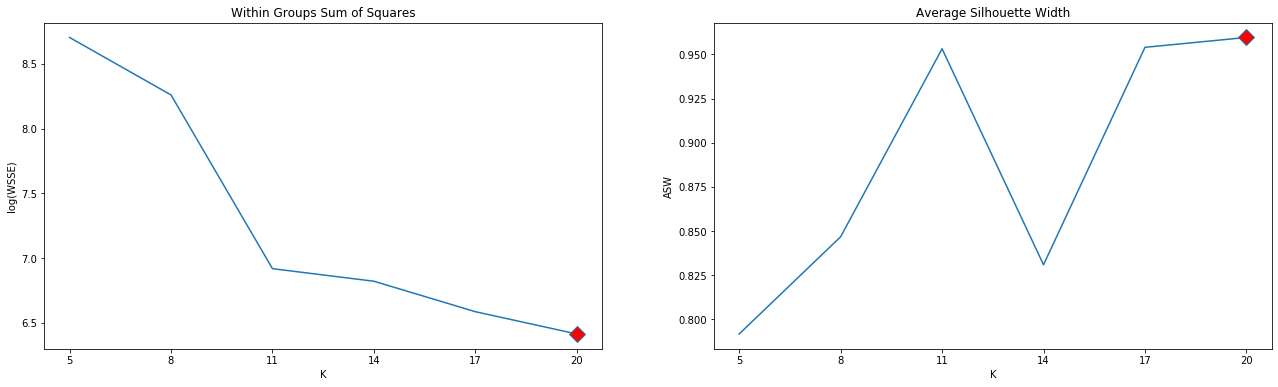

In [48]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(22,6))

best_K_wsse = np.argmin(wsse)
best_K_silhouette = np.argmax(silhouette)

_ = plt.subplot(1,2,1)
_ = plt.plot(k_list, np.log(wsse),'-D', markevery=[best_K_wsse], markerfacecolor='red', markersize=12)
# _ = plt.Circle(xy=(16,16257), radius=3, color="red")
_ = plt.xlabel("K")
_ = plt.ylabel("log(WSSE)")
_ = plt.xticks(k_list)
_ = plt.title("Within Groups Sum of Squares")

_ = plt.subplot(1,2,2)
_ = plt.plot(k_list, silhouette,'-D', markevery=[best_K_silhouette], markerfacecolor='red', markersize=12)
_ = plt.xlabel("K")
_ = plt.ylabel("ASW")
_ = plt.xticks(k_list)
_ = plt.title("Average Silhouette Width")
plt.show()

#### Posterior checks 

In [113]:
# from pyspark.ml.clustering import KMeansModel

# clustering_model = []
# for k in [4,8,12]:
#     clustering_model.append(KMeansModel.load("kmeans_k{}_trained".format(k)))

In [49]:
import numpy as np

for model in clustering_model:
    print("\n\nkmeans: K = {}".format(model.summary.k))
    print("Maximum number of iterations: {}".format(model.summary.numIter))
    
    # sort cluster sizes
    ord_sizes = model.summary.clusterSizes
    ord_idx = list(np.argsort(model.summary.clusterSizes))
    ord_sizes.sort(reverse=True)
    ord_idx.reverse()
    print("Cluster sizes:")
    for el in zip(ord_idx, ord_sizes):
        print("{}".format(el))



kmeans: K = 5
Maximum number of iterations: 2
Cluster sizes:
(1, 77714)
(2, 37277)
(0, 36580)
(3, 17321)
(4, 5028)


kmeans: K = 8
Maximum number of iterations: 2
Cluster sizes:
(1, 77737)
(3, 52540)
(0, 17269)
(5, 16223)
(6, 4870)
(4, 2401)
(7, 1723)
(2, 1157)


kmeans: K = 11
Maximum number of iterations: 4
Cluster sizes:
(1, 77712)
(3, 31856)
(0, 20126)
(2, 17255)
(5, 16214)
(4, 4549)
(6, 2401)
(8, 1721)
(10, 1204)
(9, 557)
(7, 325)


kmeans: K = 14
Maximum number of iterations: 2
Cluster sizes:
(1, 77697)
(4, 20449)
(0, 20127)
(2, 17255)
(5, 16214)
(13, 11745)
(3, 4546)
(7, 1942)
(10, 1061)
(6, 1045)
(8, 618)
(9, 520)
(11, 379)
(12, 322)


kmeans: K = 17
Maximum number of iterations: 2
Cluster sizes:
(1, 77697)
(4, 31686)
(0, 20110)
(2, 17255)
(5, 16214)
(3, 3868)
(15, 1942)
(9, 1564)
(10, 657)
(7, 618)
(8, 552)
(12, 486)
(6, 443)
(11, 322)
(16, 237)
(14, 143)
(13, 126)


kmeans: K = 20
Maximum number of iterations: 5
Cluster sizes:
(1, 76307)
(2, 31671)
(0, 20045)
(4, 17252)
(5,

In [50]:
import pyspark.sql.functions as F

for model in clustering_model:
    grouped_pred = model.summary.predictions.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("stop_token_1").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |77714        |
|2         |37277        |
|0         |36578        |
|3         |17321        |
|4         |5028         |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |77737        |
|3         |52539        |
|0         |17269        |
|5         |16223        |
|6         |4870         |
|4         |2401         |
|7         |1723         |
|2         |1156         |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |77712        |
|3         |31856        |
|0         |20125        |
|2         |17255        |
|5         |16214        |
|4         |4549         |
|6         |2401         |
|8         |1721         |
|10        |1203         |
|9         |557          |
|7         |325          |
+----------+-------------+

+----------+-------------

In [51]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_column = [1 if x=="." else 0 for x in string]
    if np.sum(is_column) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
    else:
        if is_url(string) or is_ipv6(string) or is_address(string):
            string = replace_string         
    return(string)


def abstract_address(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    return(tks)

# transform in user defined function
abstract_address_udf = udf(abstract_address, StringType())

In [52]:
import pyspark.sql.functions as F

for model in clustering_model:
    data_subset = model.summary.predictions
    data_subset = data_subset.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))

    grouped_pred = data_subset.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|3         |12012        |
|4         |4891         |
|0         |923          |
|2         |235          |
|1         |41           |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|0         |11960        |
|6         |4870         |
|3         |723          |
|2         |415          |
|1         |43           |
|4         |39           |
|7         |33           |
|5         |17           |
+----------+-------------+

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|2         |11948        |
|4         |4549         |
|3         |600          |
|10        |462          |
|7         |325          |
|0         |69           |
|6         |39           |
|1         |39           |
|8         |31           |
|9         |29           |
|5         |8            |
+----------+-------------+

+----------+-------------

In [53]:
%%time

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

kmeans_models = []
clustering_model = []


k_best = 11
for i, k in enumerate([k_best]):
    kmeans_models.append(KMeans(featuresCol='features',k=k, initMode='k-means||',
    initSteps=10, tol=0.00001, maxIter=30, distanceMeasure='cosine'))
    clustering_model.append(kmeans_models[i].fit(train_data))
    
    # compute metrics   
    wsse = clustering_model[i].summary.trainingCost
    silhouette = evaluator.evaluate(clustering_model[i].summary.predictions)

    print("With K={}".format(k))
    print("Within Cluster Sum of Squared Errors = " + str(wsse))
    print("Silhouette with cosine distance = " + str(silhouette))
    print('--'*30)

With K=11
Within Cluster Sum of Squared Errors = 1010.3240827014754
Silhouette with cosine distance = 0.9478755318659997
------------------------------------------------------------
CPU times: user 621 ms, sys: 333 ms, total: 955 ms
Wall time: 3min 11s


#### Clusters' sizes

In [54]:
import numpy as np

for model in [clustering_model[0]]:
    print("\n\nkmeans: K = {}".format(model.summary.k))
    print("Maximum number of iterations: {}".format(model.summary.numIter))
    
    # sort cluster sizes
    ord_sizes = model.summary.clusterSizes
    ord_idx = list(np.argsort(model.summary.clusterSizes))
    ord_sizes.sort(reverse=True)
    ord_idx.reverse()
    print("Cluster sizes:")
    for el in zip(ord_idx, ord_sizes):
        print("{}".format(el))



kmeans: K = 11
Maximum number of iterations: 5
Cluster sizes:
(1, 77712)
(3, 31856)
(0, 20126)
(2, 17255)
(5, 16214)
(4, 4549)
(6, 2401)
(8, 1721)
(10, 1204)
(9, 557)
(7, 325)


#### Clusters' unique messages

In [55]:
import pyspark.sql.functions as F

for model in [clustering_model[0]]:
    grouped_pred = model.summary.predictions.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("stop_token_1").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|1         |77712        |
|3         |31856        |
|0         |20125        |
|2         |17255        |
|5         |16214        |
|4         |4549         |
|6         |2401         |
|8         |1721         |
|10        |1203         |
|9         |557          |
|7         |325          |
+----------+-------------+



#### Clusters' unique messages after abstraction 

In [56]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def is_url(string):
    if string.find("://") != -1:
        return(True)
    return(False)
    

def is_ipv6(string):
    import numpy as np
    is_column = [1 if x==":" else 0 for x in string]
    if np.sum(is_column) >= 3 and string.find("/") == -1:
        return(True)
    return(False)

def is_address(string):
    import numpy as np
    is_column = [1 if x=="." else 0 for x in string]
    if np.sum(is_column) >= 2 and string.find("/") == -1:
        return(True)
    return(False)

def replace_address(string, replace_string=None):
    if not replace_string:
        if is_url(string):
            string = "$URL"
        elif is_ipv6(string):
            string = "$IPv6"
        elif is_address(string):
            string = "$ADDRESS"
    else:
        if is_url(string) or is_ipv6(string) or is_address(string):
            string = replace_string         
    return(string)


def abstract_address(tokens_list):
    '''Take a string and split url into netloc + path'''
    tks = [replace_address(x) for x in tokens_list]
    return(tks)

# transform in user defined function
abstract_address_udf = udf(abstract_address, StringType())

In [57]:
import pyspark.sql.functions as F

for model in [clustering_model[0]]:
    data_subset = model.summary.predictions
    data_subset = data_subset.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))

    grouped_pred = data_subset.groupBy("prediction")
    grouped_pred.agg(F.countDistinct("abstract_tokens").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(truncate=False)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|2         |11948        |
|4         |4549         |
|3         |600          |
|10        |462          |
|7         |325          |
|0         |69           |
|1         |39           |
|6         |39           |
|8         |31           |
|9         |29           |
|5         |8            |
+----------+-------------+



In [60]:
from termcolor import colored

clust_ids = ["5", "9", "8", "6", "1", "0", "10"]

data_subset = clustering_model[0].summary.predictions.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))


for clust_id in clust_ids:
    
    print( colored("Cluster n.{}".format(clust_id), 'red'))
    cluster = data_subset.filter("prediction == {}".format(clust_id))
    
    cluster_unique_messages = cluster.select("abstract_tokens").distinct()
    cluster_unique_messages.show(truncate=False)

Cluster n.5
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                               |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[transfer, globus_ftp_client, server, responded, error, 451, general, problem, problem, connected, $ADDRESS, la, m, quina, remota, ha, reiniciat, la, connexi]|
|[transfer, globus_ftp_client, server, responded, error, 451, general, problem, failed, connect, $ADDRESS, hi, ha, cap, cam, cap, l, estaci]                   |
|[transfer, globus_ftp_client, server, responded, error, 451, general, problem, failed, connect, $ADDRESS, la, connexi, ha, expirat]                           |
|[transfer, globus_ftp

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                                                                                                                                      |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[srm-ifce, err, communication, error, send, err, [se][ls][], $U

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                                                                                                                                                                                                           |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract_tokens                                                                                                                                                                                                                                                                                                                                                            |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
clust_ids = ["5", "9", "8", "6", "1", "0", "10"]

data_subset = clustering_model[0].summary.predictions.withColumn("abstract_tokens", abstract_address_udf("stop_token_1"))


for clust_id in clust_ids:
    cluster = data_subset.filter("prediction == {}".format(clust_id))
    
    cluster_unique_messages = cluster.select("t__error_message").distinct()
    cluster_unique_messages.show(truncate=False)

#### Small clusters 

##### Cluster 7 

In [26]:
clust_id = "7"
smaller_cluster = results.filter("prediction == {}".format(clust_id))

smaller_cluster_unique_messages = smaller_cluster.select("stop_token").distinct()
smaller_cluster_unique_messages.count()

5

In [27]:
smaller_cluster_unique_messages.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|stop_token                                                                                                                                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[transfer, globus_ftp_client:, the, server, responded, with, an, error, 535, authentication, failed:, path, validation, failed:, path, validation, failed, for, cn=17

##### Cluster 5 

In [ ]:
clust_id = "5"
smaller_cluster = results.filter("prediction == {}".format(clust_id))

smaller_cluster_unique_messages = smaller_cluster.select("stop_token").distinct()
smaller_cluster_unique_messages.count()

In [34]:
smaller_cluster_unique_messages.show(truncate=False)

+------------------------------------------------------------------------------------------------+
|stop_token                                                                                      |
+------------------------------------------------------------------------------------------------+
|[transfer, an, end-of-file, was, reached, globus_xio:, an, end, of, file, occurred]             |
|[destination, checksum, an, end-of-file, was, reached, globus_xio:, an, end, of, file, occurred]|
|[source, checksum, an, end-of-file, was, reached, globus_xio:, an, end, of, file, occurred]     |
|[an, end-of-file, was, reached, globus_xio:, an, end, of, file, occurred]                       |
+------------------------------------------------------------------------------------------------+



#### Bigger cluster

In [32]:
clust_id = "13"
bigger_cluster = results.filter("prediction == {}".format(clust_id))

bigger_cluster_unique_messages = bigger_cluster.select("stop_token").distinct()
bigger_cluster_unique_messages.count()

738

In [ ]:
# bigger_cluster_unique_messages.show(truncate=False)

#### Look at unique messages in each cluster


In [51]:
import pyspark.sql.functions as F
results.groupBy("prediction").agg(F.countDistinct("stop_token").alias("n_unique_mess")).orderBy("n_unique_mess", ascending=False).show(n=27)

+----------+-------------+
|prediction|n_unique_mess|
+----------+-------------+
|        10|        17505|
|        15|        13198|
|         3|         7699|
|        26|         6474|
|        17|         4755|
|         8|         1404|
|        19|         1249|
|        13|          738|
|        21|          349|
|        22|          191|
|         6|          151|
|         4|           57|
|        11|           27|
|        23|           16|
|        25|           14|
|        12|           13|
|         1|           10|
|         7|            5|
|         5|            4|
|        16|            4|
|        20|            3|
|         2|            3|
|        18|            3|
|         0|            2|
|        14|            2|
|         9|            1|
|        24|            1|
+----------+-------------+



In [3]:
from urllib.parse import urlparse

In [55]:
mess = vector_data.select("stop_token").limit(1).collect()[-1][0]#.show(7, truncate=False)

In [56]:
mess

['source',
 'checksum',
 'globus_ftp_client:',
 'the',
 'server',
 'responded',
 'with',
 'an',
 'error',
 '500',
 'error:',
 'commands',
 'denied']

In [57]:
for token in mess:
    print(token, "\n", urlparse(token), "\n\n")

source 
 ParseResult(scheme='', netloc='', path='source', params='', query='', fragment='') 


checksum 
 ParseResult(scheme='', netloc='', path='checksum', params='', query='', fragment='') 


globus_ftp_client: 
 ParseResult(scheme='', netloc='', path='globus_ftp_client:', params='', query='', fragment='') 


the 
 ParseResult(scheme='', netloc='', path='the', params='', query='', fragment='') 


server 
 ParseResult(scheme='', netloc='', path='server', params='', query='', fragment='') 


responded 
 ParseResult(scheme='', netloc='', path='responded', params='', query='', fragment='') 


with 
 ParseResult(scheme='', netloc='', path='with', params='', query='', fragment='') 


an 
 ParseResult(scheme='', netloc='', path='an', params='', query='', fragment='') 


error 
 ParseResult(scheme='', netloc='', path='error', params='', query='', fragment='') 


500 
 ParseResult(scheme='', netloc='', path='500', params='', query='', fragment='') 


error: 
 ParseResult(scheme='error', netlo

In [35]:
for token in mess:
    parsed = urlparse(token)
    if parsed.scheme:
        if parsed.path:
            print("\n\nTrue: {}\n".format(token), parsed.path)
        else:
            print("\n\nTrue: {}\n".format(token), parsed.scheme)
    else:
        print("\n\nTrue: {}\n".format(token), parsed.path)



True: destination
 destination


True: overwrite
 overwrite


True: srm-ifce
 srm-ifce


True: err:
 err


True: communication
 communication


True: error
 error


True: on
 on


True: send,
 send,


True: err:
 err


True: [se][srmrm][]
 [se][srmrm][]


True: httpg://tbn18.nikhef.nl:8446/srm/managerv2:
 /srm/managerv2:


True: cgsi-gsoap
 cgsi-gsoap


True: running
 running


True: on
 on


True: fts706.cern.ch
 fts706.cern.ch


True: reports
 reports


True: could
 could


True: not
 not


True: open
 open


True: connection
 connection


True: to
 to


True: tbn18.nikhef.nl:8446
 tbn18.nikhef.nl:8446


In [61]:
def deal_with_urls(url):
    from urllib.parse import urlparse
    parsed = urlparse(url)
    if parsed.scheme:
        if parsed.path:
            res = ' '.join([parsed.scheme + "://" + parsed.netloc, parsed.path])
        else:
            res = parsed.scheme + ":"
    else:
        res = parsed.path
    return(res)



def split_urls(string):
    '''Take a string and split url into netloc + path'''
    from urllib.parse import urlparse
    tks = [deal_with_urls(x) for x in string.split()]
    return(' '.join(tks))

In [43]:
deal_with_urls("httpg://tbn18.nikhef.nl:8446/srm/managerv2:")

'httpg://tbn18.nikhef.nl:8446 /srm/managerv2:'

In [48]:
vector_data.columns

['vo',
 'src_url',
 'dst_url',
 'src_hostname',
 'dst_hostname',
 't_channel',
 'timestamp_tr_st',
 'timestamp_tr_comp',
 't_error_code',
 'tr_error_scope',
 't_failure_phase',
 'tr_error_category',
 't_final_transfer_state',
 't__error_message',
 'hlg',
 'tokens',
 'stop_token',
 'count_vec',
 'tf_idf']

In [59]:
mess = vector_data.select("t__error_message").limit(7).collect()[-1][0]#.show(7, truncate=False)
mess

'DESTINATION OVERWRITE srm-ifce err: Communication error on send, err: [SE][srmRm][] httpg://tbn18.nikhef.nl:8446/srm/managerv2: CGSI-gSOAP running on fts706.cern.ch reports could not open connection to tbn18.nikhef.nl:8446'

In [51]:
split_urls(mess)

'DESTINATION OVERWRITE srm-ifce err Communication error on send, err [SE][srmRm][] httpg://tbn18.nikhef.nl:8446 /srm/managerv2: CGSI-gSOAP running on fts706.cern.ch reports could not open connection to tbn18.nikhef.nl:8446'

In [62]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# transform in user defined function
split_urls_udf = udf(split_urls, StringType())

# create high level groups
temp = test_data.select("t__error_message").withColumn("new_mess", split_urls_udf("t__error_message"))

In [64]:
temp.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|t__error_message                                                                                                                                                                                                                                                                                      |new_mess                                                                                                          